In [625]:
# Generating a toy dataset.
# DO NOT MODIFY THIS PART

import numpy as np
import math
import random as rand

paras = list((rand.random() - 0.5 for _ in range(13)))

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def y_gen(x):
    h_11 = sigmoid(paras[0] * x[0] + paras[1] * x[1] + paras[2])
    h_12 = sigmoid(paras[3] * x[0] + paras[4] * x[1] + paras[5])
    h_13 = sigmoid(paras[6] * x[0] + paras[7] * x[1] + paras[8])
    h_21 = sigmoid(paras[9] * h_11 + paras[10] * h_12 + paras[11] * h_13 + paras[12])
    return h_21 + ((rand.random()-0.5)/100 if rand.random()>0.6 else 0)

n = 300
x = list(zip((rand.random() - 0.5 for _ in range(n)), (rand.random() - 0.5 for _ in range(n))))
y = list(map(y_gen, x))
y = [(i-min(y))/(max(y)-min(y)) for i in y]

from sklearn.model_selection import train_test_split

r = 0.2
x_train_valid, x_test, y_train_valid, y_test = train_test_split(x, y, test_size=r)
x_train, x_valid, y_train, y_valid = train_test_split(x_train_valid, y_train_valid, test_size=r)

In [626]:
def initialize_parameters():
    # Layer 1: weights and biases (3 neurons, each with 2 inputs)
    W1 = np.random.uniform(-1, 1, (3, 2))
    b1 = np.zeros((3, 1))

    # Layer 2: weights and biases (1 neuron, with 3 inputs from Layer 1)
    W2 = np. random.uniform(-1, 1, (1, 3))
    b2 =  np. zeros((1, 1))

    return W1, b1, W2, b2


In [627]:


def forward_propagation(x, W1, b1, W2, b2):
    Z1 =  np.dot(W1, x) + b1
    A1 =  sigmoid(Z1)
    Z2 =  np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)
    return A1, A2


In [628]:
def sigmoid_derivative(A):
    return A * (1 - A)

In [629]:
def backward_propagation(x, y, A1, A2, W1, W2):
    # Error at output layer
    dZ2 = A2 - y
    dW2 =  np.dot(dZ2, A1.T)
    db2 = np.sum(dZ2, axis=1, keepdims=True)  # Sum across samples if batched
    # Backpropagate to Layer 1
    dA1 =  np.dot(W2.T, dZ2)
    dZ1 = dA1 * sigmoid_derivative(A1)  # Apply derivative of sigmoid
    dW1 =  np.dot(dZ1, x.T)
    db1 = np.sum(dZ1, axis=1, keepdims=True)  # Sum across samples if batched

    return dW1, db1, dW2, db2

In [630]:
def update_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate):
    W1 -=   learning_rate * dW1
    b1 -=  learning_rate * db1
    W2 -=  learning_rate * dW2
    b2 -= learning_rate * db2
    return W1, b1, W2, b2

In [631]:
def mse_loss(y_true, y_pred):
   cost= (1/2) *  np.sum((y_true - y_pred) ** 2)
   return  cost

In [632]:
def compute_cost(data, labels, W1, b1, W2, b2):
    total_loss = 0
    n = len(data)  # number of samples
    for x, y in zip(data, labels):
        _, A2 =  forward_propagation(np.array(x).reshape(-1, 1), W1, b1, W2, b2)
        total_loss += mse_loss(y, A2)
        total = total_loss / n 
    return total 

In [633]:
def train_model(x_train, y_train, x_valid, y_valid, epochs, initial_lr, patience=10):
    W1, b1, W2, b2 = initialize_parameters()
    train_costs = []
    valid_costs = []
    best_loss = float('inf')
    no_improve_epoch = 0
    
    for epoch in range(epochs):
        lr = initial_lr * (0.5 ** (epoch // 20))  # every 50 epoch
        
        for x, y in zip(x_train, y_train):
            x_array = np.array(x).reshape(-1, 1)  

            y_array = np.array(y).reshape(-1, 1) 

            A1, A2 =  forward_propagation(x_array, W1, b1, W2, b2)
            dW1, db1, dW2, db2 =  backward_propagation(x_array, y_array, A1, A2, W1, W2)
            W1, b1, W2, b2 =update_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, lr)
        # Calculate loss
        train_cost =   compute_cost(x_train, y_train, W1, b1, W2, b2)
        valid_cost =  compute_cost(x_valid, y_valid, W1, b1, W2, b2)
        train_costs. append(train_cost)
        valid_costs.   append(valid_cost)
        #early stop
        if valid_cost < best_loss:
            best_loss = valid_cost
            no_improve_epoch = 0
        else:
            no_improve_epoch += 1    
        if no_improve_epoch >= patience:
            print(f"Stopping early at epoch {epoch}")
            break
        if epoch % 10 == 0:
            print(f"Epoch {epoch}: Training Loss = {train_cost}, Validation Loss = {valid_cost}, Learning Rate = {lr}")
    return W1, b1, W2, b2, train_costs, valid_costs



In [634]:
import matplotlib.pyplot as plt
def plot_costs(train_costs, valid_costs):
    plt.figure(figsize=(10, 5))
    plt.plot(train_costs, label='Training cost')
    plt.plot(valid_costs, label='Validation cost')
    plt.ylabel('Cost')
    plt.xlabel('Epochs')
    plt.title('Training and Validation Cost')
    plt.legend()
    plt.show()

In [635]:
import matplotlib.pyplot as plt
def plot_predictions(x_test, y_test, W1, b1, W2, b2):
    predictions = []
    for x in x_test:
        x_array = np.array(x).reshape(-1, 1)
        _, pred = forward_propagation(x_array, W1, b1, W2, b2)
        predictions.append(pred.item())

    plt.figure(figsize=(10, 5))
    plt.scatter([y for y in y_test], predictions, alpha=0.5)
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title('True and Predicted Outputs')
    plt.show()

Epoch 0: Training Loss = 0.01465494147195111, Validation Loss = 0.014814849373303155, Learning Rate = 0.1
Epoch 10: Training Loss = 0.003443632173970888, Validation Loss = 0.0025656732002684378, Learning Rate = 0.1
Epoch 20: Training Loss = 0.002928256914248447, Validation Loss = 0.0022016270417606633, Learning Rate = 0.05
Stopping early at epoch 30


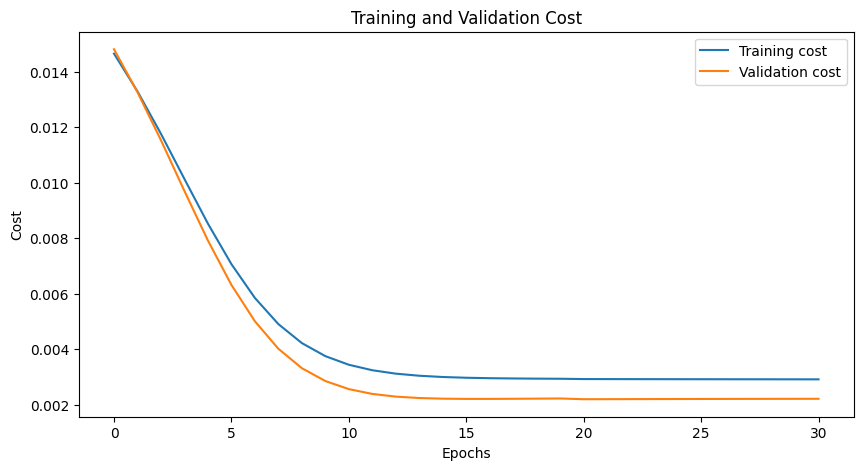

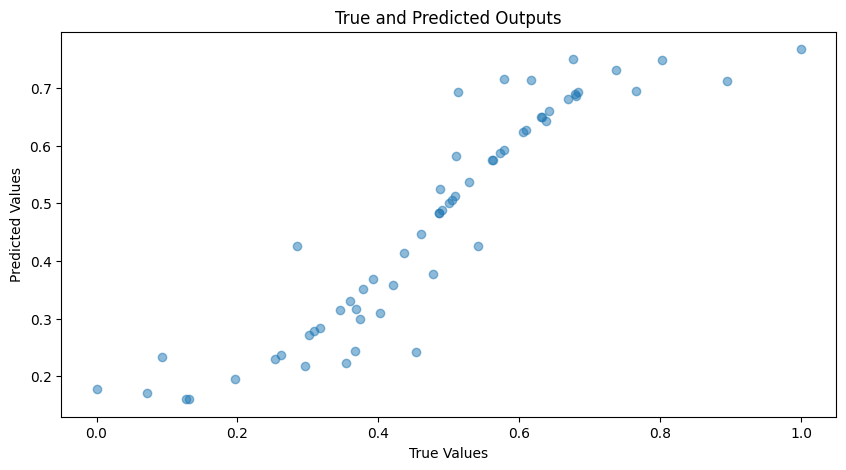

In [636]:
W1, b1, W2, b2, train_costs, valid_costs = train_model(x_train, y_train, x_valid, y_valid, 1000, 0.1)
plot_costs(train_costs, valid_costs)
plot_predictions(x_test, y_test, W1, b1, W2, b2)